In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import s2fft
from astropy.units import s as seconds
from lunarsky import Time
from pygdsm import GlobalSkyModel16

import croissant as cro

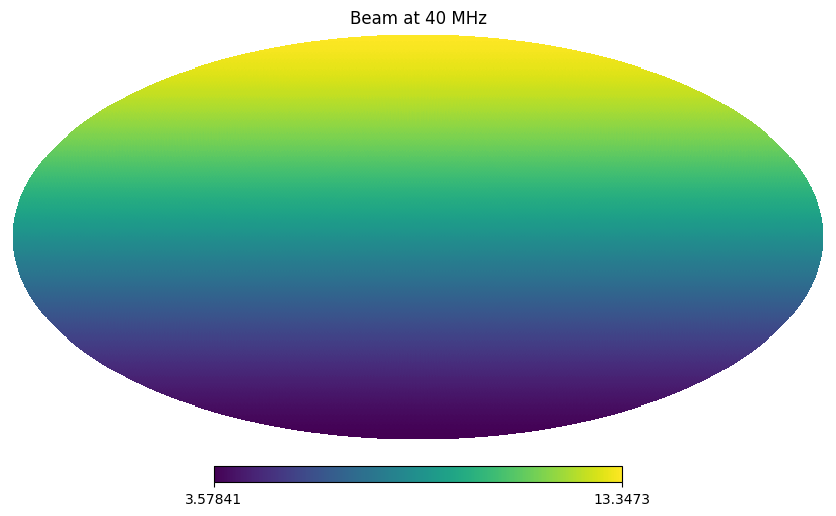

In [2]:
# simple beam in topocentric coordinates
freq = np.linspace(40, 80, 41)
nside = 64


phi = cro.utils.generate_phi(sampling="healpix", nside=nside)
theta = cro.utils.generate_theta(sampling="healpix", nside=nside)
y10 = 1 / 2 * np.sqrt(3 / np.pi) * np.cos(theta)

beam_data = 30 * cro.constants.Y00 + 10 * y10
beam_data = (freq[:, None] / freq[0]) ** 2 * beam_data[None, :]

beam = cro.Beam(
    beam_data,
    freqs=freq,
    sampling="healpix",
    horizon=None,  # default horizon
)

hp.mollview(beam.data[0], title=f"Beam at {freq[0]:.0f} MHz")

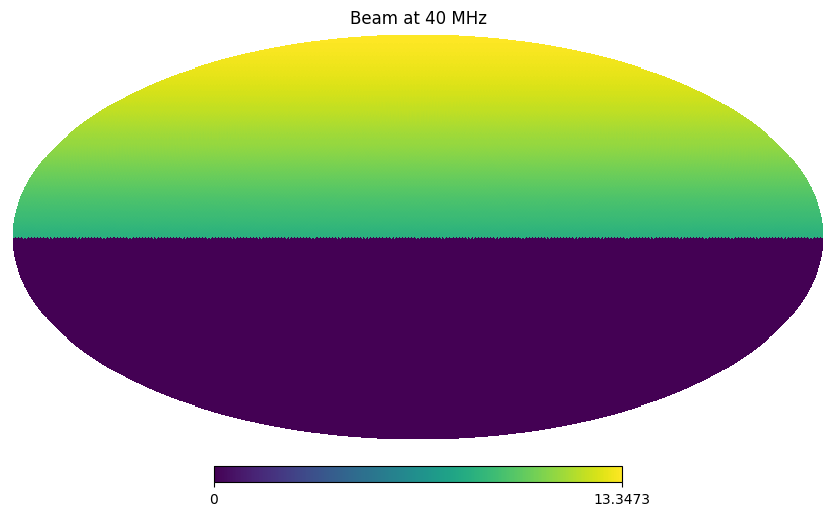

In [3]:
# the beam has a horizon attribute that gets invoked in simulations
hp.mollview(beam.data[0] * beam.horizon, title=f"Beam at {freq[0]:.0f} MHz")

We use the Global Sky Model (Zheng et al 2016) at as the sky model. 

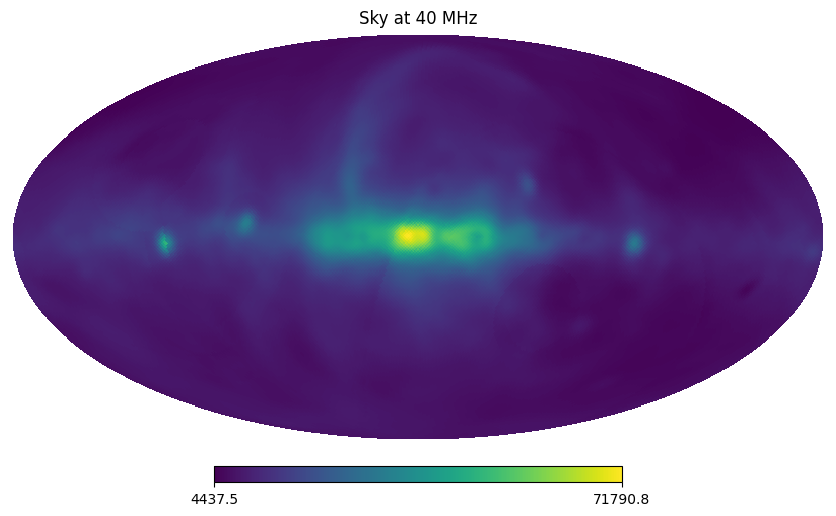

In [4]:
gsm = GlobalSkyModel16(
    freq_unit="MHz", data_unit="TRJ", resolution="lo", include_cmb=True
)
sky_map = gsm.generate(beam.freqs)
sky = cro.Sky(sky_map, freq)
hp.mollview(sky.data[0], title=f"Sky at {freq[0]:.0f} MHz")

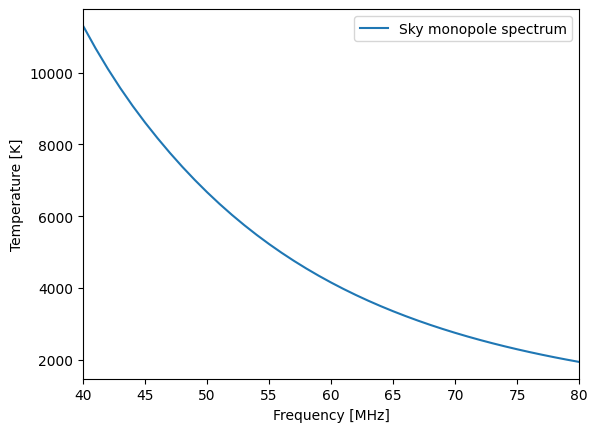

In [5]:
plt.figure()
plt.plot(sky.freqs, sky.data.mean(axis=1), label="Sky monopole spectrum")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Temperature [K]")
plt.xlim(sky.freqs.min(), sky.freqs.max())
plt.legend()
plt.show()

In [6]:
# let's do a full sidereal day on the moon
lon = -10
lat = 20
t_start = Time("2022-06-02 15:43:43")
t_end = t_start + cro.constants.sidereal_day_moon * seconds
times = cro.utils.time_array(t_start=t_start, t_end=t_end, N_times=300)
sim = cro.Simulator(beam, sky, times.jd, freq, lon, lat, world="moon", Tgnd=0)

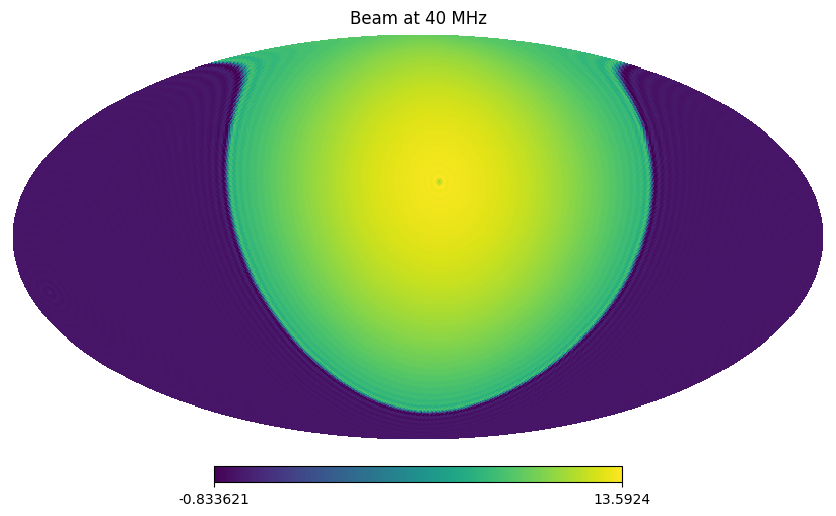

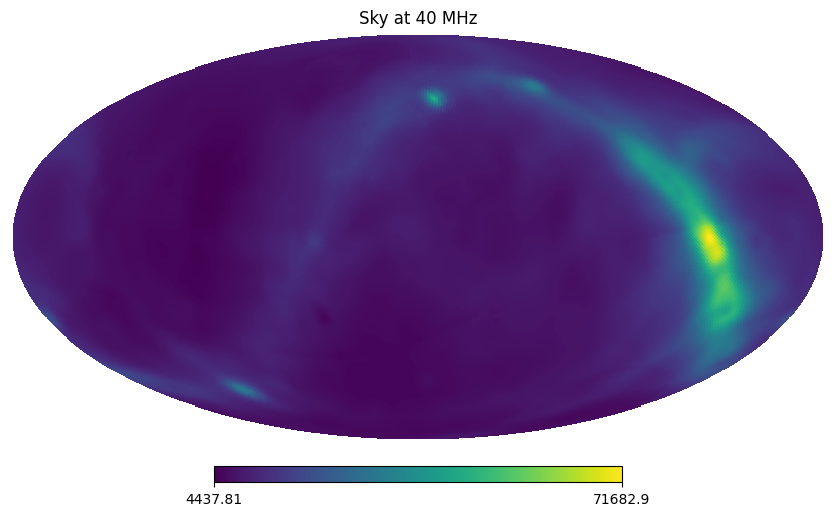

In [7]:
# the simulator view of the beam and sky after moving to MCMF coordinates
beam_eq_alm = sim.compute_beam_eq()
sky_eq_alm = sim.sky.compute_alm_eq(world=sim.world)

beam_eq = s2fft.inverse_jax(
    beam_eq_alm[0],
    sim.beam.lmax + 1,
    nside=nside,
    sampling="healpix",
    reality=True,
)
sky_eq = s2fft.inverse_jax(
    sky_eq_alm[0],
    sim.sky.lmax + 1,
    nside=nside,
    sampling="healpix",
    reality=True,
)

hp.mollview(beam_eq, title=f"Beam at {freq[0]:.0f} MHz")
hp.mollview(sky_eq, title=f"Sky at {freq[0]:.0f} MHz")

Run the simulator!

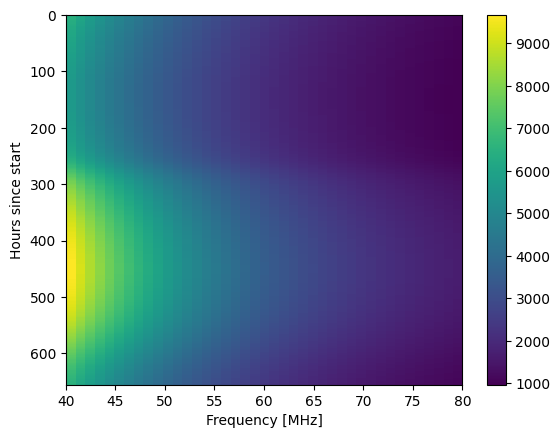

In [8]:
vis = sim.sim()

dt = (t_end.jd - t_start.jd) * 24
plt.figure()
plt.imshow(
    vis, aspect="auto", interpolation="none", extent=[freq[0], freq[-1], dt, 0]
)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Hours since start")
plt.colorbar()
plt.show()

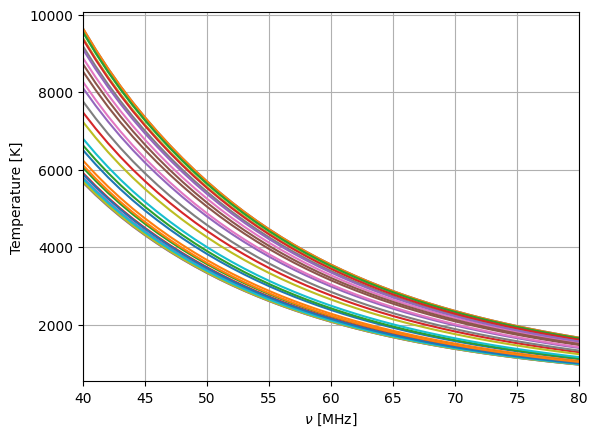

In [9]:
# different colors represent different times
plt.figure()
plt.plot(sim.freqs, vis[::10].T, ls="-")
plt.xlim(sim.freqs.min(), sim.freqs.max())
plt.xlabel("$\\nu$ [MHz]")
plt.ylabel("Temperature [K]")
plt.grid()
plt.show()

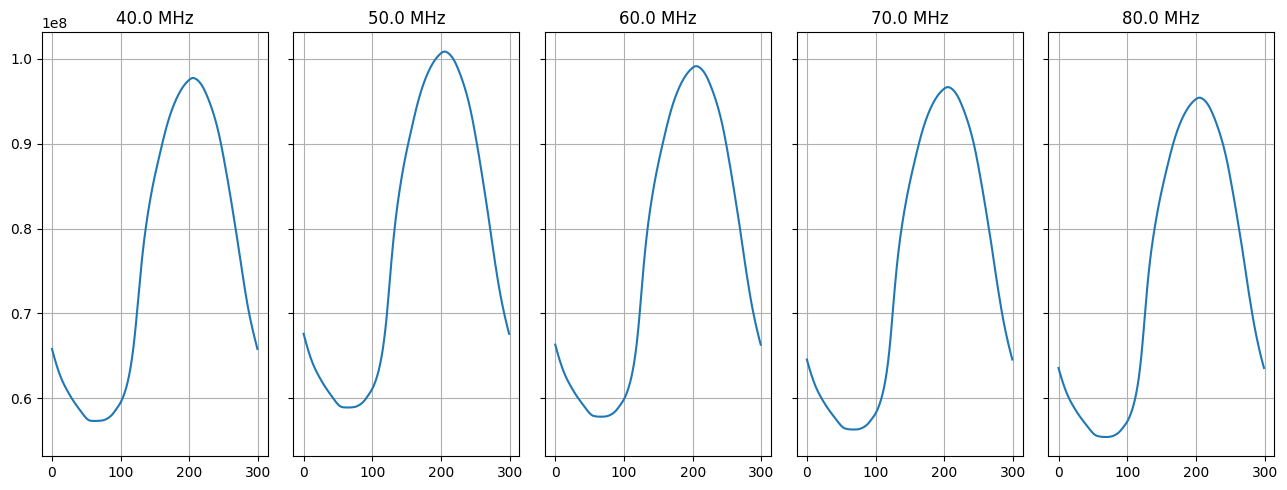

In [10]:
# Temp vs time
fig, axs = plt.subplots(figsize=(13, 5), ncols=5, sharex=True, sharey=True)
for i, f in enumerate(sim.freqs[::10]):
    ax = axs.ravel()[i]
    fidx = np.argwhere(sim.freqs == f)[0, 0]
    ax.plot(vis[:, fidx] * f**2.5)
    ax.set_title(f"{f} MHz")
    ax.grid()
plt.tight_layout()
plt.show()

# On Earth

In [11]:
# change sidereal_day_moon to sidereal_day_earth
t_end = t_start + cro.constants.sidereal_day_earth * seconds
times = cro.utils.time_array(t_start=t_start, t_end=t_end, N_times=300)
sim = cro.Simulator(beam, sky, times.jd, freq, lon, lat, world="earth", Tgnd=0)

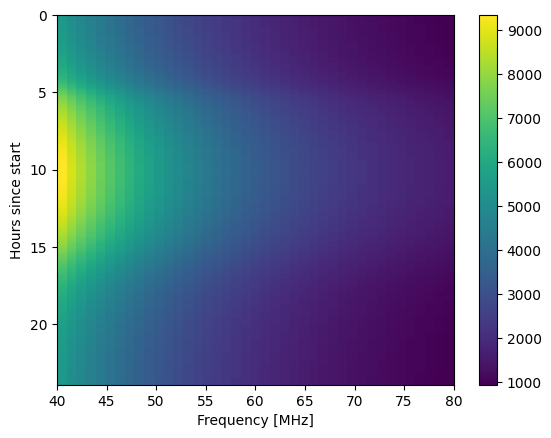

In [12]:
vis = sim.sim()

dt = (t_end.jd - t_start.jd) * 24
plt.figure()
plt.imshow(
    vis, aspect="auto", interpolation="none", extent=[freq[0], freq[-1], dt, 0]
)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Hours since start")
plt.colorbar()
plt.show()

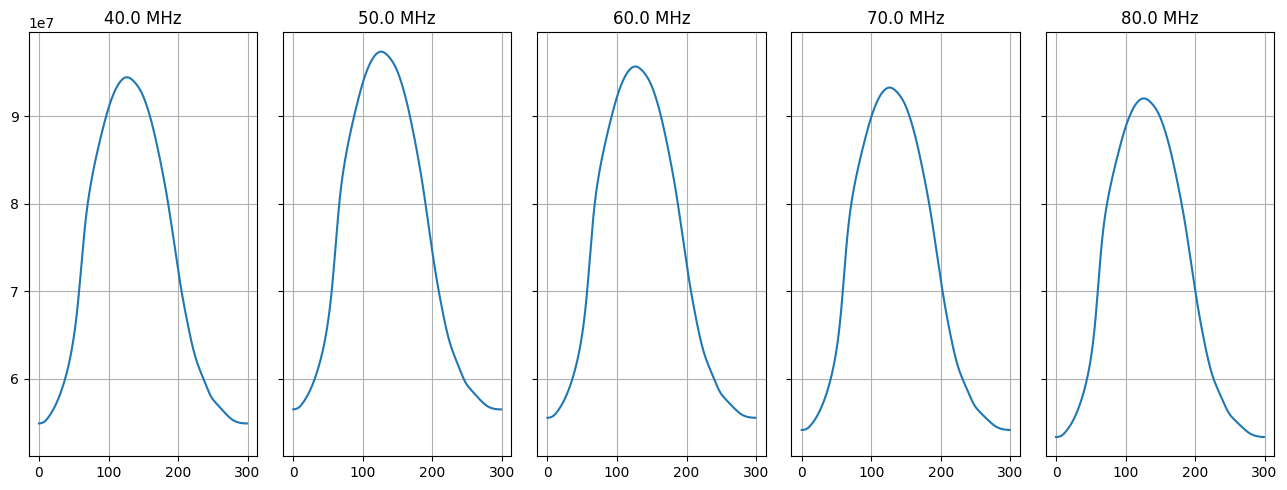

In [13]:
# Temp vs time
fig, axs = plt.subplots(figsize=(13, 5), ncols=5, sharex=True, sharey=True)
for i, f in enumerate(sim.freqs[::10]):
    ax = axs.ravel()[i]
    fidx = np.argwhere(sim.freqs == f)[0, 0]
    ax.plot(vis[:, fidx] * f**2.5)
    ax.set_title(f"{f} MHz")
    ax.grid()
plt.tight_layout()
plt.show()